In [2]:
# Cell 0 - Preparation: load packages, set some basic options  
%matplotlib inline
import obspy
from obspy.signal.invsim import cosine_taper 
from obspy.signal.filter import lowpass
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from matplotlib import rcParams
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 7
rcParams["figure.subplot.hspace"] = (0.5)

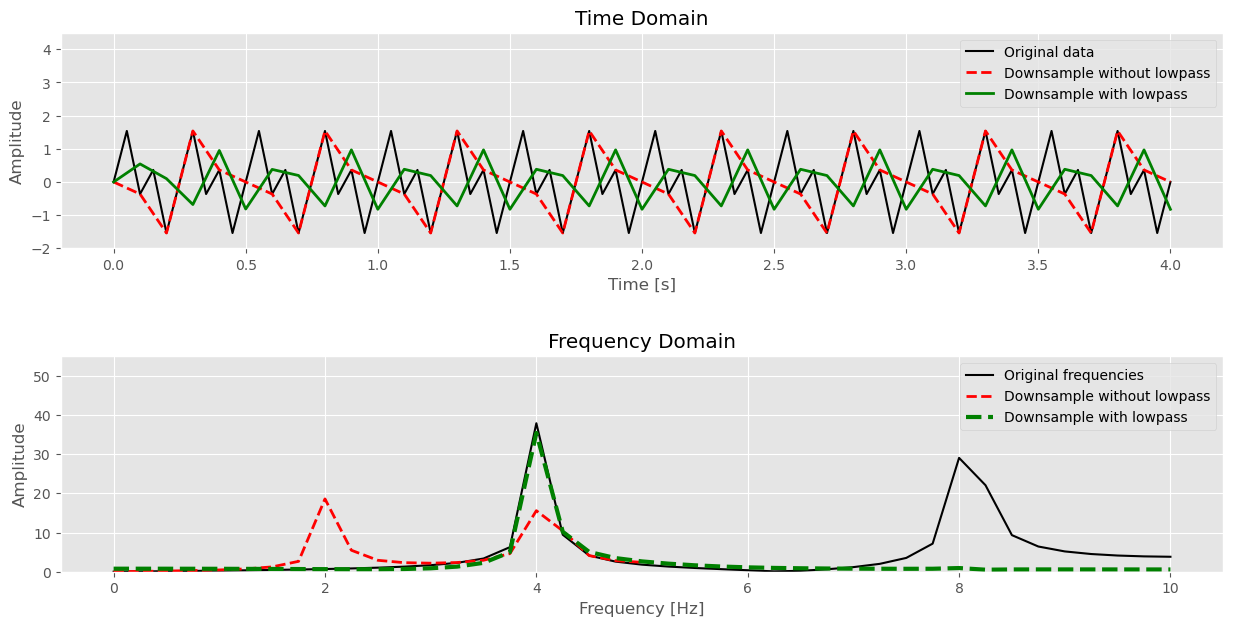

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Cell 1: downsampling + Nyquist
npts = 512                              # number of samples
nsec = 4.0                              # length of signal in seconds
df = 20.0                               # sampling rate
fNy = df / 2.0                          # Nyquist frequency
fg1 = 8                                 # generator frequency 1 (initial: 8 Hz)
fg2 = 4                                 # generator frequency 2 (initial: 4 Hz)
time = np.linspace(0, nsec, int(nsec * df) + 1)  # time axis for plotting

y  = np.sin(2 * np.pi * fg1 * time)     # set up a test signal from two frequencies
y += np.sin(2 * np.pi * fg2 * time) 

# downsample to 10 Hz by taking every second element
y_2 = y[::2]

# downsample after lowpassing the signal
# Assure-toi que la fonction lowpass est définie ou importée correctement
y_l = lowpass(y, 5.0, df=df, corners=4, zerophase=False)  # à adapter si nécessaire
y_new = y_l[::2]

y_f = np.fft.rfft(y)                    # transform all 3 signals into frequency domain 
y_f2 = np.fft.rfft(y_2)                 # applying Fourier transformation via FFT
y_fnew = np.fft.rfft(y_l)
freq = np.linspace(0, fNy, len(y_f))    # frequency axis for plotting

# plot
plt.subplot(211)
plt.plot(time, y, 'k', label="Original data", lw=1.5)
plt.plot(time[::2], y_2, 'r--', label="Downsample without lowpass", lw=2)
plt.plot(time[::2], y_new, 'g', label="Downsample with lowpass", lw=2)
plt.legend()
plt.ylim(-2, 4.5)
plt.title('Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(freq, abs(y_f), 'k', label="Original frequencies", lw=1.5)
plt.plot(freq[:len(y_f2)], abs(y_f2), 'r--', label="Downsample without lowpass", lw=2)
plt.plot(freq[:len(y_fnew)], abs(y_fnew), 'g--', label="Downsample with lowpass", lw=3)
plt.legend()
plt.ylim(0, 55)
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()


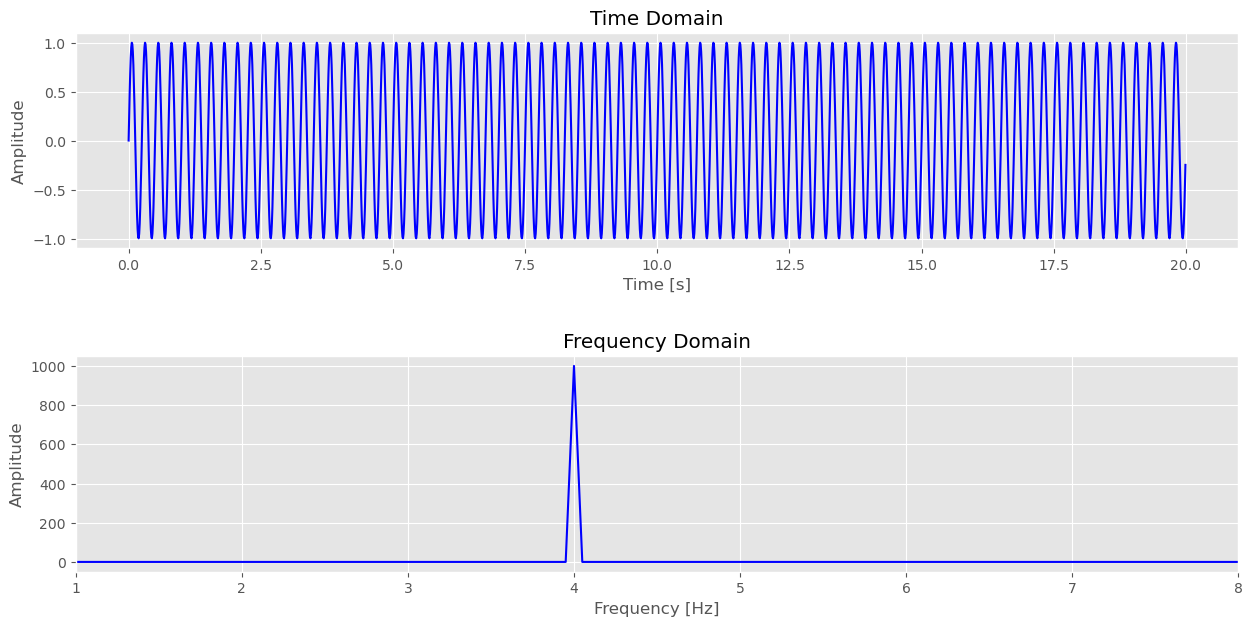

In [4]:
# Cell 2: spectral leakage
leng = 20.0                           # length of signal in seconds (initial: 2 s)
dt = 1./100.                         # sampling interval
ny = 1/(2.*dt)                       # Nyquist frequency
t = np.arange(0, leng, dt)           # time axis for plotting
sin  = np.sin(2 * 4 * np.pi * t)     # set up a sine wave as signal

Fsin = np.fft.rfft(sin)              # FFT to frequency domain
f = np.linspace(0, ny, len(Fsin))    # frequency axis for plotting

# plot
plt.subplot(211)
plt.plot(t, sin, 'b')
plt.title('Time Domain')
plt.ylim(-1.1,1.1)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(f, abs(Fsin), 'b')
plt.xlim(1,8)
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

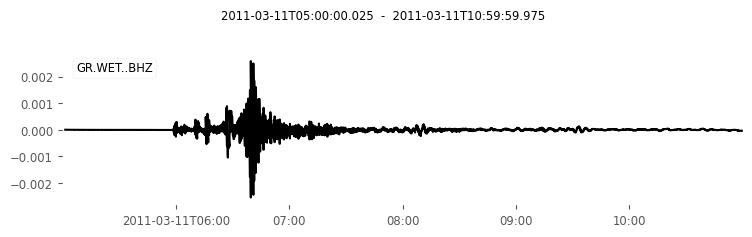

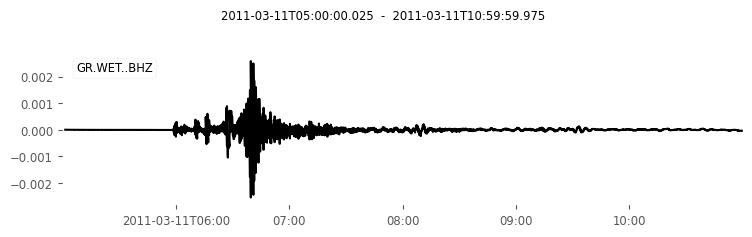

In [5]:
# Cell 3: prepare data from Tohoku earthquake. 
client = Client("BGR")
t1 = UTCDateTime("2011-03-11T05:00:00.000")
st = client.get_waveforms("GR", "WET", "", "BHZ", t1, t1 + 6 * 60 * 60, 
                          attach_response = True)
st.remove_response(output="VEL")
st.detrend('linear')
st.detrend('demean')
st.plot()

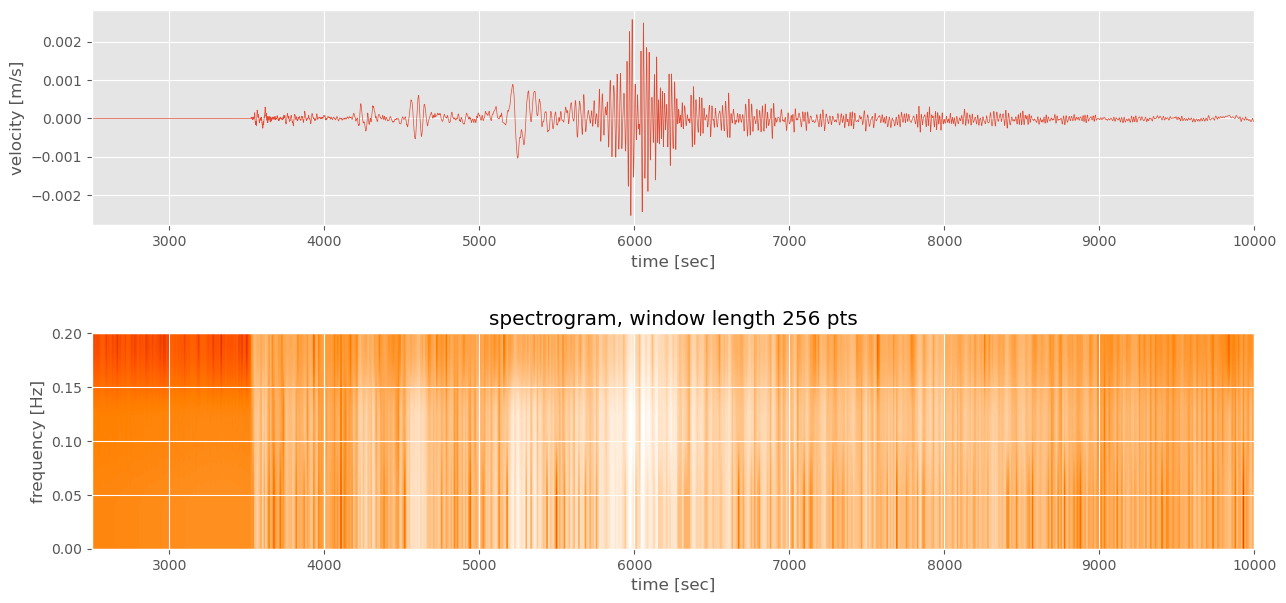

In [10]:
# Cell 4 - spectrogram
tr = st[0]
NFFT = 256    # length of spectrogram window in sample points (initial: 256)
# number of sample points that the sliding window overlaps, must be less than NFFT
noverlap = 50  
xstart = 2500    # x axis limits in the plot
xend = 10000  # max. length of signal: 21627 sec

# plot
ax1 = plt.subplot(211)
plt.plot(tr.times(), tr.data, linewidth=0.5)
plt.xlabel('time [sec]')
plt.ylabel('velocity [m/s]')

plt.subplot(212, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT)
Pxx, freqs, bins, im = plt.specgram(
    tr.data, NFFT=NFFT, Fs=tr.stats.sampling_rate, 
    noverlap=noverlap,cmap=plt.cm.gist_heat)

# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage instance
plt.ylabel('frequency [Hz]')
plt.xlabel('time [sec]')
plt.ylim(0,0.2)

plt.xlim(xstart, xend)
plt.show()

Before Taper
amplitude of first sample point:   0.9
amplitude of last sample point:  -0.9
After Taper
amplitude of first sample point:   0.0
amplitude of last sample point:  -0.0


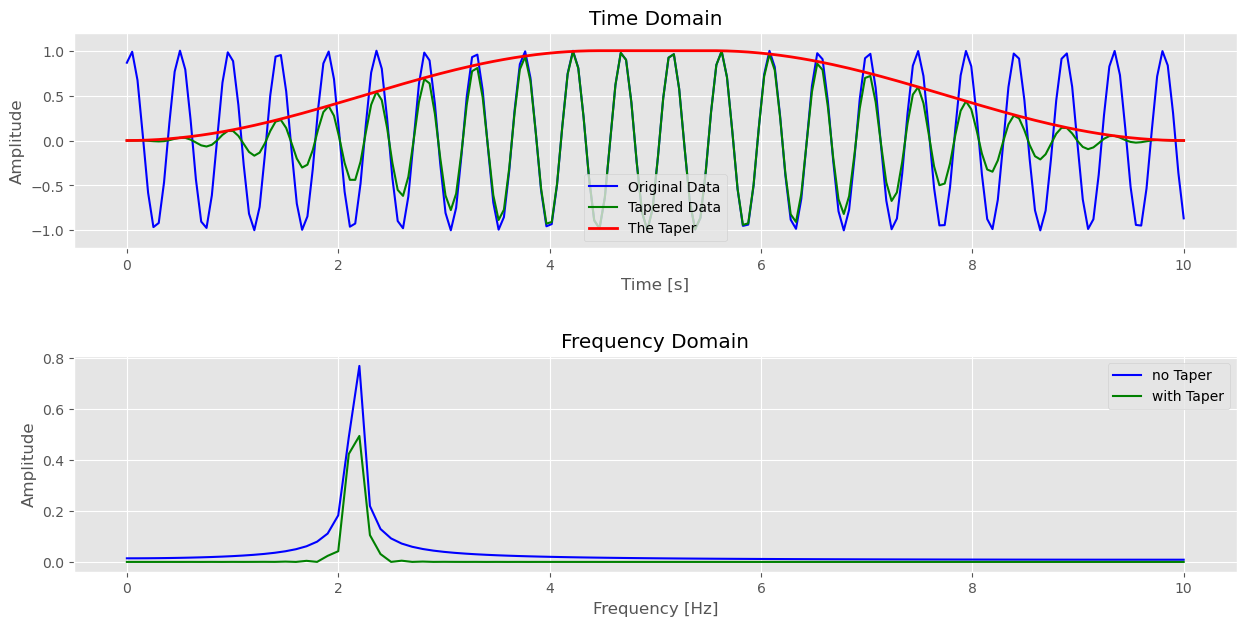

In [14]:
# Cell 5 - tapers  
samp = 200                                # number of sample point (initial: 200)
delta = 0.05                              # sample spacing (initial: 0.05)
freq1 = 2.15                              # generator freq to create signal (initial: 2.15)
freq2 = 7.8                               # generator freq to create signal (initial: 7.8)
temp = np.linspace(0.0, samp*delta, samp) # time axis in seconds

# generate freq1 Hz sine wave signal
dat = np.sin(freq1 * 2.0 * np.pi * temp)
# add an offset for the zero point of the sinewave
dat = np.sin(freq1 * 2.0 * np.pi * temp + np.pi/3)
## add another sinusoid to signal with freq2 Hz
#dat = dat + np.sin(freq2 * 2.0 * np.pi * temp + np.pi/3)
#noise_amplitude = 0.7
## add noise to the signal
#dat = dat + np.random.randn(len(dat)) * noise_amplitude 
# determine max. amplitude of data (for plotting)
maximum = max(dat)

print('Before Taper')
print('amplitude of first sample point:%6.1f' %dat[0])
print('amplitude of last sample point:%6.1f' %(dat[len(dat)-1]))

# percentage of taper applied [0. ; 1.] (initial: 0.1)
taper_percentage = 0.9
# define taper window
taper = cosine_taper(samp,taper_percentage)
# taper the signal
dat_taper = dat * taper

print('After Taper')
print('amplitude of first sample point:%6.1f' %dat_taper[0])
print('amplitude of last sample point:%6.1f' %(dat_taper[len(dat_taper)-1]))

# FFT data into frequency-domain
Fdat = np.fft.rfft(dat, n=samp)
Fdat_taper = np.fft.rfft(dat_taper, n=samp)
# x-axis in f-domain for plotting
#xf = np.linspace(0.0, 1.0/(2.0*delta), (samp/2)+1)
xf = np.linspace(0.0, 1.0/(2.0*delta), int(samp/2) + 1)

# plot
plt.subplot(211)
plt.title('Time Domain')
plt.plot(temp, dat, label="Original Data", color='b', linewidth=1.5)
plt.plot(temp, dat_taper, label="Tapered Data", color='g',linewidth=1.5)
plt.plot(temp, taper, label="The Taper", color='r', linewidth=2)
plt.legend(loc='lower center')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.ylim(-(maximum+0.2),maximum+0.2)

plt.subplot(212)
plt.title('Frequency Domain')
plt.plot(xf, 2.0/samp * np.abs(Fdat), color='b',label="no Taper",linewidth=1.5)
plt.plot(xf, 2.0/samp * np.abs(Fdat_taper), label="with Taper", color='g',linewidth=1.5)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

3 Trace(s) in Stream:
BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples

BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


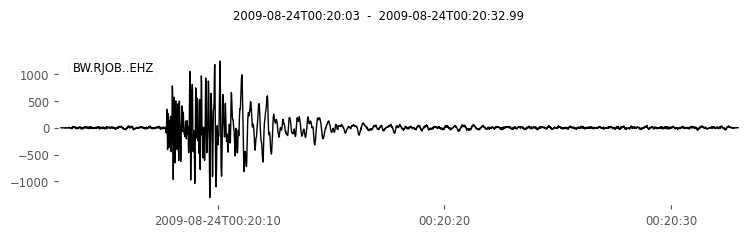

In [15]:
# Cell 6 - load the data
st = obspy.read()             # read in example seismogram included in obspy
print(st)
print('')
tr = st[0]                    # take only the vertical trace of the stream
print(tr)
tr.filter("highpass", freq=2) # removing long-period noise
tr.plot()
tr_safe = tr.copy()           # safety copy to not override our data

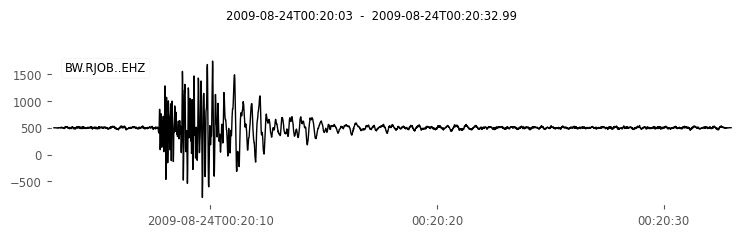

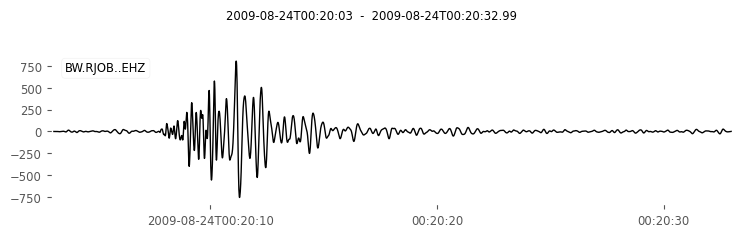

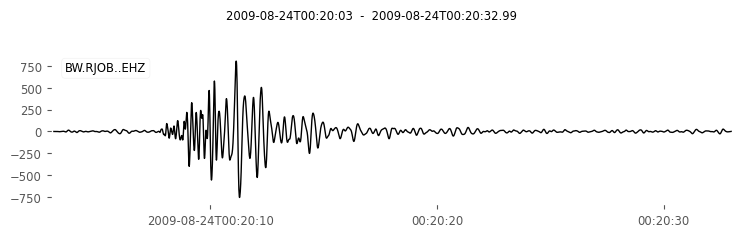

In [19]:
# Cell 7 - offsets 

tr = tr_safe.copy()       # load a fresh version of the data
tr.data += 500            # creating an offset
tr.plot()
tr.detrend('demean')     # correction
tr.filter('bandpass', freqmin=0.01, freqmax=5)
tr.plot()

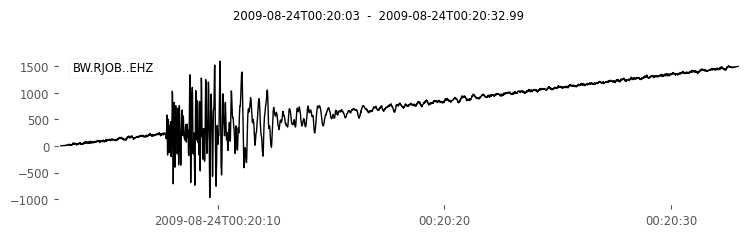

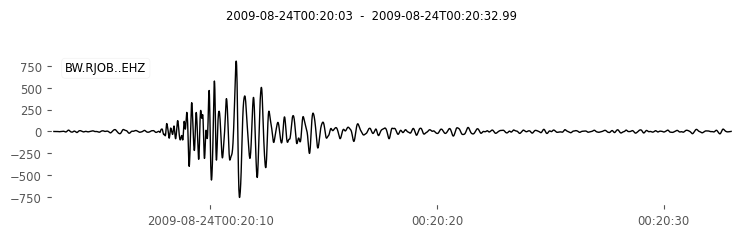

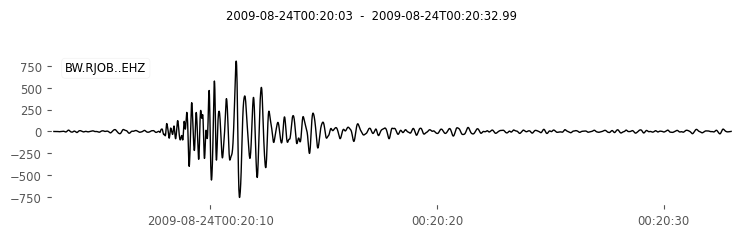

In [20]:
# Cell 8 - linear trend 

tr = tr_safe.copy()         # load a fresh version of the data
tr.data += 50. * tr.times() # creating a linear trend
tr.plot()
tr.detrend('linear')       # correction
#tr.plot()
tr.filter('bandpass', freqmin=0.01, freqmax=5.)
tr.plot()

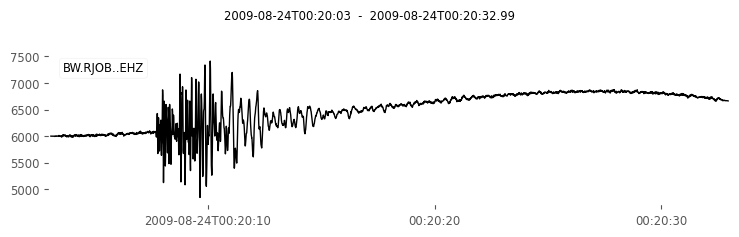

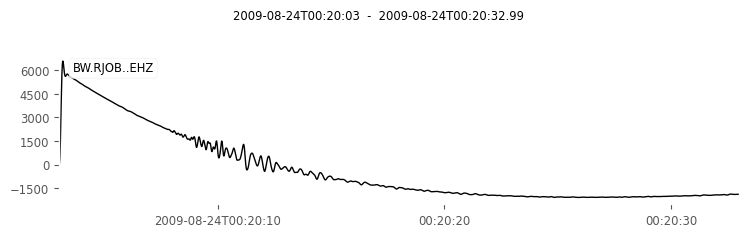

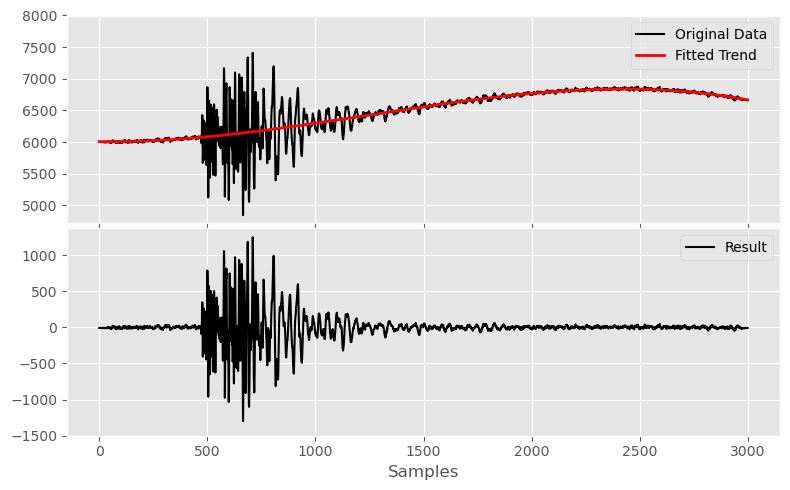

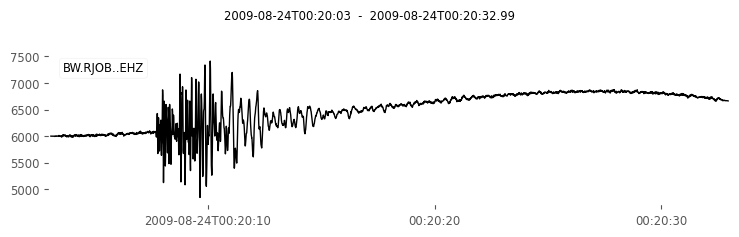

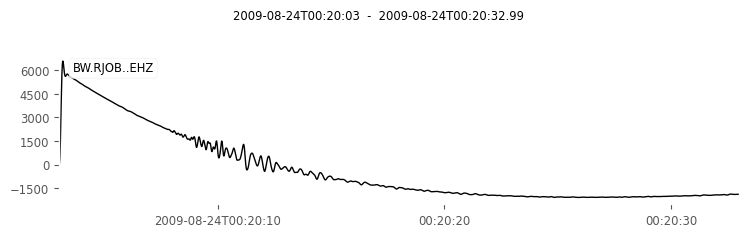

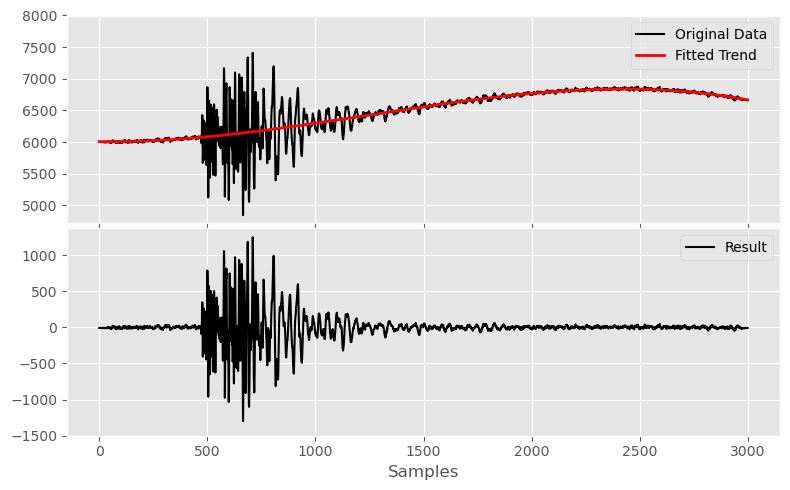

array([-7.62347721, -7.56983735, -7.46558542, ..., -7.7632266 ,
       -8.14886349, -8.46755388])

In [18]:
# Cell 9 - any polynomial trend

# load a fresh version of the data
tr = tr_safe.copy()
# "spoiling" the data
tr.data += 6000 + 4 * tr.times() ** 2
# further "spoiling" the data
tr.data -= 0.1 * tr.times() ** 3 + 0.00001 * tr.times() ** 5

tr.plot()
tmp = tr.copy()
tmp.filter('bandpass', freqmin=0.01, freqmax=5)
tmp.plot()

# taking the data as array out of trace container
data = tr.data                                           
# correct the spoiled data and plot+print it
obspy.signal.detrend.polynomial(data, order=3, plot=True)# Cell 9 - any polynomial trend

# load a fresh version of the data
tr = tr_safe.copy()
# "spoiling" the data
tr.data += 6000 + 4 * tr.times() ** 2
# further "spoiling" the data
tr.data -= 0.1 * tr.times() ** 3 + 0.00001 * tr.times() ** 5

tr.plot()
tmp = tr.copy()
tmp.filter('bandpass', freqmin=0.01, freqmax=5)
tmp.plot()

# taking the data as array out of trace container
data = tr.data                                           
# correct the spoiled data and plot+print it
obspy.signal.detrend.polynomial(data, order=3, plot=True)